# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
import numpy as np
import matplotlib.pyplot as plt
from io import StringIO
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split as tts
from sklearn import tree
from sklearn import metrics
from IPython.display import Image
import pydotplus

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 130000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (130000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(111488, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

85.76

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(111486, 10)


1    93593
0    17893
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.
The tree came with no problems. It was packed well, no issues with the packaging or anything, it was all perfectly intact. It is very healthy, with a ton of buds and has no problems whatsoever. Fancy fancy little tree.
First of all, I would like to comment regarding previous reviews. I do not think the first review in 2005 was done by an employee, and that's not really a fair statement but rather an assumption lacking any real fact or evidence. It seems like a very small company that just enjoys making cheese straws and wants to share them with others. I sincerely doubt that, at the great price they are, the company even makes a ton of profit - which is a shame.<br /><br />Secondly, after tasting Aunt Lizzie's cheese straws for the first time this Fall, I will not eat anyone else's. I literally threw away a package of a VERY POPULAR chee

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.
The tree came with no problems. It was packed well, no issues with the packaging or anything, it was all perfectly intact. It is very healthy, with a ton of buds and has no problems whatsoever. Fancy fancy little tree.
First of all, I would like to comment regarding previous reviews. I do not think the first review in 2005 was done by an employee, and that's not really a fair statement but rather an assumption lacking any real fact or evidence. It seems like a very small company that just enjoys making cheese straws and wants to share them with others. I sincerely doubt that, at the great price they are, the company even makes a ton of profit - which is a shame.Secondly, after tasting Aunt Lizzie's cheese straws for the first time this Fall, I will not eat anyone else's. I literally threw away a package of a VERY POPULAR cheese straw com

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

First of all, I would like to comment regarding previous reviews. I do not think the first review in 2005 was done by an employee, and that is not really a fair statement but rather an assumption lacking any real fact or evidence. It seems like a very small company that just enjoys making cheese straws and wants to share them with others. I sincerely doubt that, at the great price they are, the company even makes a ton of profit - which is a shame.<br /><br />Secondly, after tasting Aunt Lizzie is cheese straws for the first time this Fall, I will not eat anyone else is. I literally threw away a package of a VERY POPULAR cheese straw company that I received yesterday as a gift because when I tasted them, they just tasted bland and floury. I could not even bring myself to finish them. I crave Aunt Lizzie is cheese straws so much. (I recommend trying them with some Shiraz or other wine!)<br /><br />Our company gave out Aunt Lizzie is cheese straws as a corporate customer gift this year, 

In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

First of all I would like to comment regarding previous reviews I do not think the first review in 2005 was done by an employee and that is not really a fair statement but rather an assumption lacking any real fact or evidence It seems like a very small company that just enjoys making cheese straws and wants to share them with others I sincerely doubt that at the great price they are the company even makes a ton of profit which is a shame br br Secondly after tasting Aunt Lizzie is cheese straws for the first time this Fall I will not eat anyone else is I literally threw away a package of a VERY POPULAR cheese straw company that I received yesterday as a gift because when I tasted them they just tasted bland and floury I could not even bring myself to finish them I crave Aunt Lizzie is cheese straws so much I recommend trying them with some Shiraz or other wine br br Our company gave out Aunt Lizzie is cheese straws as a corporate customer gift this year and I bet that Aunt Lizzie will

In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
%%time
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████| 111486/111486 [00:41<00:00, 2677.72it/s]

Wall time: 41.6 s


In [23]:
preprocessed_reviews[1500]

'first would like comment regarding previous reviews not think first review done employee not really fair statement rather assumption lacking real fact evidence seems like small company enjoys making cheese straws wants share others sincerely doubt great price company even makes ton profit shame secondly tasting aunt lizzie cheese straws first time fall not eat anyone else literally threw away package popular cheese straw company received yesterday gift tasted tasted bland floury could not even bring finish crave aunt lizzie cheese straws much recommend trying shiraz wine company gave aunt lizzie cheese straws corporate customer gift year bet aunt lizzie slew new customers thanks aunt lizzie'

In [24]:
final['Text']=preprocessed_reviews 
fd = final.sample(n=100000)
# Sorting based on time
fd['Time'] = pd.to_datetime(fd['Time'], origin='unix', unit='s')
fd= fd.sort_values('Time')
fd.shape

(100000, 10)

In [25]:
#splitting data into X and Y
Y= fd.Score
X=fd.Text
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, shuffle=False)# this is for time series split

print('Before Vectorization')
print('Train--->',X_train.shape, y_train.shape)
print('Test---->',X_test.shape, y_test.shape)

Before Vectorization
Train---> (67000,) (67000,)
Test----> (33000,) (33000,)


# [4] Featurization

## [4.1] BAG OF WORDS

In [26]:
%%time
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(ngram_range=(1,2),min_df=10, max_features=10000)
vectorizer.fit(X_train) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_bow = vectorizer.transform(X_train)
X_test_bow = vectorizer.transform(X_test)

print("After vectorizations")
print(X_train_bow.shape, y_train.shape)
print(X_test_bow.shape, y_test.shape)

After vectorizations
(67000, 10000) (67000,)
(33000, 10000) (33000,)
Wall time: 16.8 s


## [4.2] Bi-Grams and n-Grams.

In [30]:
#splitting data into X and Y
Y= fd.Score
X=fd.Text
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, shuffle=False)# this is for time series split
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(X_train)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (67000, 5000)
the number of unique words including both unigrams and bigrams  5000


## [4.3] TF-IDF

In [31]:
#splitting data into X and Y
Y= fd.Score
X=fd.Text
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, shuffle=False)# this is for time series split

print('Before Vectorization')
print('Train--->',X_train.shape, y_train.shape)
print('Test---->',X_test.shape, y_test.shape)

tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df = 10, max_features=10000)
tf_idf_vect.fit(X_train)

X_train_tfidf = tf_idf_vect.transform(X_train)
X_test_tfidf = tf_idf_vect.transform(X_test)

print("After vectorizations")
print(X_train_tfidf.shape, y_train.shape)
print(X_test_tfidf.shape, y_test.shape)

Before Vectorization
Train---> (67000,) (67000,)
Test----> (33000,) (33000,)
After vectorizations
(67000, 10000) (67000,)
(33000, 10000) (33000,)


## [4.4] Word2Vec

In [33]:
#splitting data into X and Y
Y= fd.Score
X=fd.Text
#splitting data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, shuffle=False) 
#before vectorization
print('Train Data' ,X_train.shape, y_train.shape)
print('Test Data',X_test.shape, y_test.shape)
i=0
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
# this line of code trains your w2v model on the give list of sentances
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

Train Data (67000,) (67000,)
Test Data (33000,) (33000,)
number of words that occured minimum 5 times  15447
sample words  ['ulcer', 'bariatric', 'tilda', 'massive', 'dolphin', 'thirst', 'brians', 'pants', 'artificially', 'gm', 'aromatics', 'cinnamon', 'offends', 'stiff', 'excellently', 'nibs', 'loosely', 'nursing', 'belgians', 'scattered', 'hunger', 'steak', 'detracts', 'brit', 'grad', 'dense', 'staleness', 'pace', 'resembling', 'chair', 'locations', 'mustards', 'traditional', 'baste', 'apples', 'suspended', 'sons', 'juice', 'along', 'halal', 'quantity', 'furballs', 'saute', 'lows', 'manageable', 'spoilage', 'scented', 'santander', 'auction', 'inspired']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

### converting train data

In [34]:
#splitting data into X and Y
Y= fd.Score
X=fd.Text
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, shuffle=False)# this is for time series split
from tqdm import tqdm
import numpy as np
i=0
list_of_sentance_train=[]
for sentance in tqdm(X_train):
    list_of_sentance_train.append(sentance.split())
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
sent_vectors_train = np.array(sent_vectors_train)
print(sent_vectors_train.shape)
print(sent_vectors_train[0])

100%|██████████| 67000/67000 [20:49<00:00, 53.61it/s]  


(67000, 50)
[ -4.75064198e-01   5.26526889e-01   2.92301565e-01   4.54120423e-01
   2.61703528e-02   4.11322455e-01  -1.97880027e-01  -2.45081057e-01
  -2.23463487e-01  -1.70892955e-01  -7.65932960e-01  -1.78232965e-01
  -7.62286519e-02  -1.35588083e-01   5.13927935e-01   1.64850693e-01
   1.60214354e-01   1.70123211e-01  -2.25134982e-02   1.11967643e-01
  -3.40365267e-01   1.67330217e-01   5.10722193e-01  -3.80800391e-01
   6.88848507e-02   2.50838513e-01   3.40428508e-01   5.78039231e-02
  -6.55146353e-01  -4.17165426e-02   7.27900356e-01   3.30357060e-02
  -5.50329730e-01   2.96901335e-01  -5.86678662e-01   1.47456924e-05
   1.50404554e-01  -2.82272406e-01   9.38561725e-02   9.50883155e-02
  -1.29079927e-01  -4.71002643e-02   1.95742286e-01   2.50434766e-01
   2.90216033e-01  -3.68373986e-01   5.24798240e-01  -2.02628982e-01
  -5.43847008e-01  -5.99114486e-01]


### converting test data

In [35]:
i=0
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
sent_vectors_test = np.array(sent_vectors_test)
print(sent_vectors_test.shape)
print(sent_vectors_test[0])

100%|██████████| 33000/33000 [10:55<00:00, 50.35it/s]


(33000, 50)
[-1.91066417 -0.89483983  2.18619494 -0.29892435 -0.85973182 -0.92049819
 -0.30439089 -0.79679147  0.68911424 -0.01726781  0.47441496 -0.26483878
  0.42188779  0.35528288  0.28652707 -0.51338014 -0.30923206  0.82266812
 -1.13580274 -0.98062177 -0.57067396  0.91557461  0.70128728  1.60973063
 -1.46431873  1.4432347   0.65928753  0.77236345 -1.47990262 -0.21748223
  0.88075148 -0.89727858 -1.68001108  1.08451485  0.00313146 -0.40026268
 -0.21988318 -1.26583602  0.42596658 -0.4487764  -0.6540429   0.39655277
  1.03846181  1.47926261  0.25632286  0.05180158  0.34946117 -0.09129011
  0.28020823 -0.24808651]


#### [4.4.1.2] TFIDF weighted W2v

In [36]:
#splitting data into X and Y
Y= fd.Score
X=fd.Text
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, shuffle=False)# this is for time series split
#before vectorization
print('Train Data' ,X_train.shape, y_train.shape)
print('Test Data',X_test.shape, y_test.shape)
model1 = TfidfVectorizer()
tf_idf_train_w2v= model1.fit_transform(X_train)
tf_idf_test_w2v= model1.transform(X_test)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary1 = dict(zip(model1.get_feature_names(), list(model1.idf_)))
print(tf_idf_train_w2v.shape, tf_idf_test_w2v.shape)

Train Data (67000,) (67000,)
Test Data (33000,) (33000,)
(67000, 47985) (33000, 47985)


### converting train data

In [37]:
i=0
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())
# TF-IDF weighted Word2Vec
tfidf_feat_train = model1.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat_train:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary1[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1
tfidf_sent_vectors_train = np.array(tfidf_sent_vectors_train)

100%|██████████| 67000/67000 [1:27:53<00:00, 12.71it/s]  


### converting test data

In [38]:
i=0
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())
# TF-IDF weighted Word2Vec
tfidf_feat_test = model1.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat_test:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary1[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1
tfidf_sent_vectors_test = np.array(tfidf_sent_vectors_test)

100%|██████████| 33000/33000 [44:22<00:00, 12.39it/s]  


In [39]:
print(tfidf_sent_vectors_train.shape,tfidf_sent_vectors_test.shape)

(67000, 50) (33000, 50)


# [5] Assignment 8: Decision Trees

<ol>
    <li><strong>Apply Decision Trees on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning (best `depth` in range [4,6, 8, 9,10,12,14,17] , and the best `min_samples_split` in range [2,10,20,30,40,50])</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Graphviz</strong>
        <ul>
    <li>Visualize your decision tree with Graphviz. It helps you to understand how a decision is being made, given a new vector.</li>
    <li>Since feature names are not obtained from word2vec related models, visualize only BOW & TFIDF decision trees using Graphviz</li>
    <li>Make sure to print the words in each node of the decision tree instead of printing its index.</li>
    <li>Just for visualization purpose, limit max_depth to 2 or 3 and either embed the generated images of graphviz in your notebook, or directly upload them as .png files.</li>                
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Find the top 20 important features from both feature sets <font color='red'>Set 1</font> and <font color='red'>Set 2</font> using `feature_importances_` method of <a href='https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html'>Decision Tree Classifier</a> and print their corresponding feature names</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/Gp2DQmh.jpg' width=500px> with X-axis as <strong>min_sample_split</strong>, Y-axis as <strong>max_depth</strong>, and Z-axis as <strong>AUC Score</strong> , we have given the notebook which explains how to plot this 3d plot, you can find it in the same drive <i>3d_scatter_plot.ipynb</i></li>
            <p style="text-align:center;font-size:30px;color:red;"><strong>or</strong></p> <br>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/fgN9aUP.jpg' width=300px> <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heat maps</a> with rows as <strong>min_sample_split</strong>, columns as <strong>max_depth</strong>, and values inside the cell representing <strong>AUC Score</strong> </li>
    <li>You choose either of the plotting techniques out of 3d plot or heat map</li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='https://i.imgur.com/wMQDTFe.jpg' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Decision Trees

# Function for finding the best depth and sample split in DecisionTree Classifier

In [40]:
def dtc(Xtrain,ytrain):
    """
    Returns : best parameters of DecisionTree Calssifier
    ---
    Input : Dataset
    """
    # https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
    import numpy as np
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.metrics import roc_auc_score
    from sklearn.model_selection import GridSearchCV
    import matplotlib.pyplot as plt
    max_depth = [ 5, 10, 50, 100, 500]
    min_samples_split = [10, 50, 100, 200, 300 ]
    parameters = {'max_depth': [5, 10, 50, 100, 500], 'min_samples_split' :[10, 50, 100,200, 300]}
    clftree = DecisionTreeClassifier()
    clf = GridSearchCV(clftree,parameters,cv=4, scoring='roc_auc',return_train_score=True)
    clf.fit(Xtrain,ytrain)
    tab = pd.DataFrame(clf.cv_results_)
    import seaborn as sns
    plt.figure(figsize=(15, 8))
    max_scores = tab.groupby(['param_max_depth','param_min_samples_split']).max()
    max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
    sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g')
    plt.title('Grid Search CV Score on Train and Test Data')
    plt.show()
    best_parameter= clf.best_params_
    print('Best depth: ', clf.best_estimator_.max_depth)
    print('Best samples split: ', clf.best_estimator_.min_samples_split)
    return clf.best_estimator_.max_depth, clf.best_estimator_.min_samples_split

# Training the model with best hyperparameter

In [41]:
def final_tree( Xtrain ,ytrain ,Xtest ,ytest , param1 , param2):
    """
    Returns : threshold values, False positive rate , True positive rate and the trained model
    ---
    Input : Train dataset, Test Dataset , best parameters
    """
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
    from sklearn.metrics import roc_curve, auc
    import matplotlib.pyplot as plt
    from sklearn.tree import DecisionTreeClassifier

    clftre = DecisionTreeClassifier(class_weight='balanced',min_samples_split=param1, max_depth=param2)
    clftre.fit(Xtrain,ytrain)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    train_fpr, train_tpr, thresholds = roc_curve(y_train, clftre.predict_proba(Xtrain)[:,1])
    test_fpr, test_tpr, thresholds = roc_curve(y_test, clftre.predict_proba(Xtest)[:,1])
    
    plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
    plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
    plt.legend()
    plt.grid(True)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.show()
    return thresholds ,train_fpr, train_tpr, clftre

## Function for picking the best threshold that will give the least fpr

In [42]:
# we are writing our own function for predict, with defined thresholds
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshold, fpr, tpr):
    """
    Input: Threshold values , false positive rate and true positive rate of final model
    ---
    Return: best threshold value for confusion matrix
    """
    import numpy as np
    t = threshold[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshold):
    predictions = []
    for i in proba:
        if i>=threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

## Function for confusion matrix for best threshold values

In [43]:
def conf_matrix(Xtrain,ytrain,Xtest,ytest,best_t,model):
    """
    Input : Train dataset, Test dataset, best threshold values for confusion matrix and final model
    ---
    Return: Confusion matrix of train and test dataset
    """
    #https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels 
    import seaborn as sns
    %matplotlib inline
    sns.set()

    y_train_pred = model.predict_proba(Xtrain)[:,1]  
    y_test_pred = model.predict_proba(Xtest)[:,1]
    from sklearn.metrics import confusion_matrix
    print('Train Data')
    cm = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
    cl = ['Negative', 'Positive']
    confusion_df = pd.DataFrame(cm, index=cl, columns=cl)
    sns.heatmap(confusion_df, annot=True, cbar = False,fmt = 'd'); #annot=True to annotate cells
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()   
    print('='*50)
    print('Test Data')
    cm_test= (confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))
    confusion_df_test = pd.DataFrame(cm_test, index=cl, columns=cl)
    sns.heatmap(confusion_df_test, annot=True, fmt = 'd'); #annot=True to annotate cells
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# [5.1] Applying Decision Trees on BOW,<font color='red'> SET 1</font>

#### Hyperparameter tuning

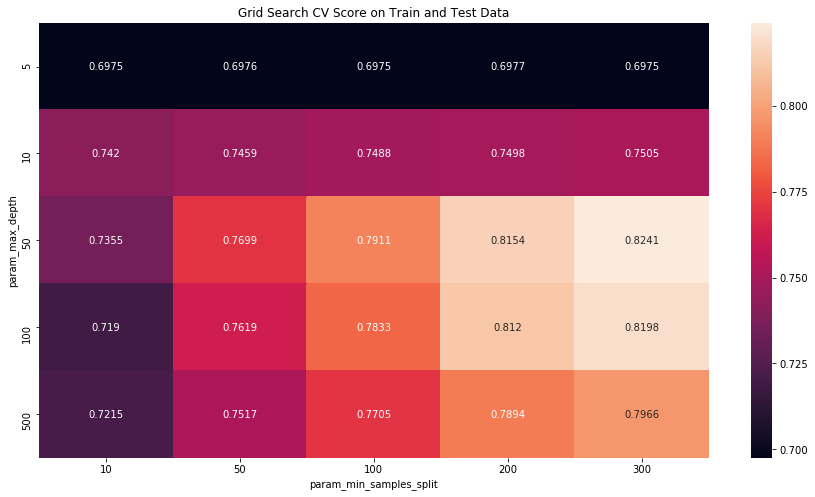

Best depth:  50
Best samples split:  300
Wall time: 22min 4s


In [44]:
%%time
best_depth_bow, best_samle_split_bow = dtc(X_train_bow,y_train)

#### Training the model with best hyperparameter

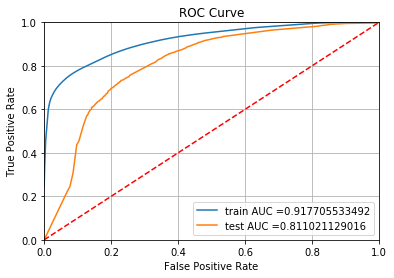

In [45]:
th_bow, fpr_bow , tpr_bow , clftre_bow = final_tree(X_train_bow,y_train, X_test_bow, y_test,best_samle_split_bow,best_depth_bow)

### [5.1.1] Top 20 important features from<font color='red'> SET 1</font>

In [46]:
ft_1 = clftre_bow.feature_importances_
bow_ft = vectorizer.get_feature_names()
temp = sorted(zip(ft_1,bow_ft))
final_feature= pd.DataFrame(temp[:-21:-1])
final_feature

,0,1
0,0.134614,not
1,0.086021,great
2,0.039527,best
3,0.038891,delicious
4,0.026466,love
5,0.023480,perfect
6,0.022880,good
7,0.021336,loves
8,0.019462,bad
9,0.019120,disappointed


### [5.1.2] Graphviz visualization of Decision Tree on BOW,<font color='red'> SET 1</font>

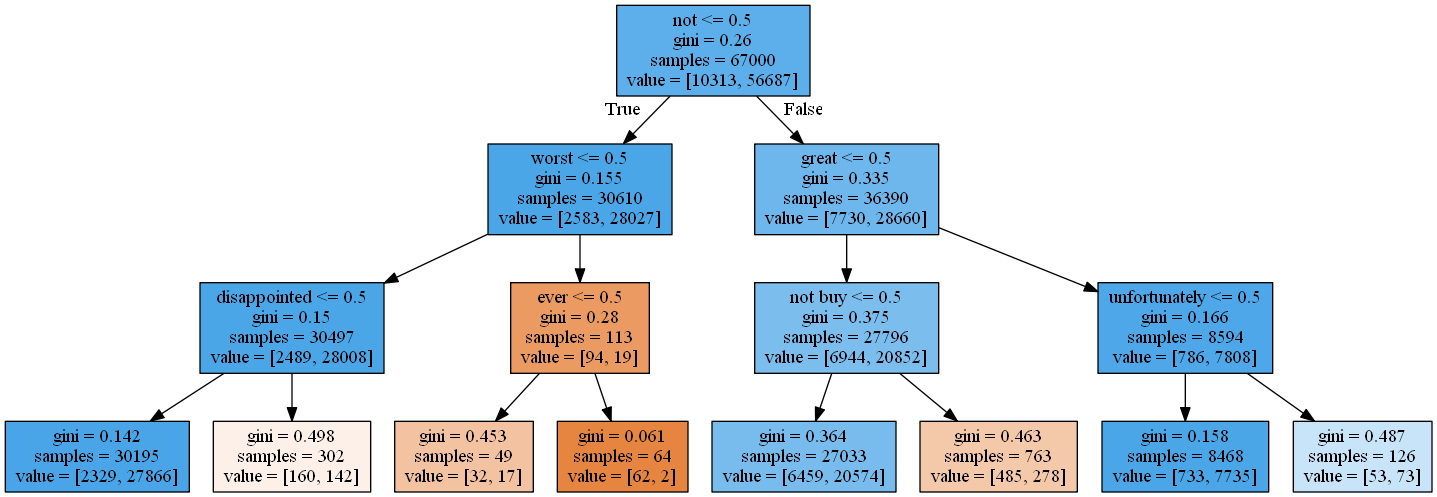

In [47]:
model_bow=tree.DecisionTreeClassifier(max_depth=3)
model_bow.fit(X_train_bow, y_train)
# Create DOT data for visualizing the tree
dot_data_bow = tree.export_graphviz(model_bow, out_file=None,feature_names=bow_ft, filled = True)

# Draw graph
graph_bow = pydotplus.graph_from_dot_data(dot_data_bow)  

# Show graph
Image(graph_bow.create_png())

#### Confusion Matrix

the maximum value of tpr*(1-fpr) 0.700822188823 for threshold 0.476
Train Data


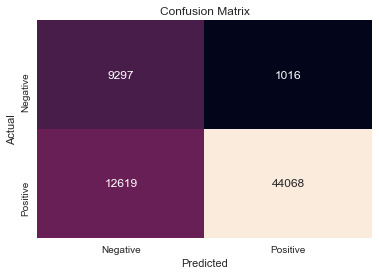

Test Data


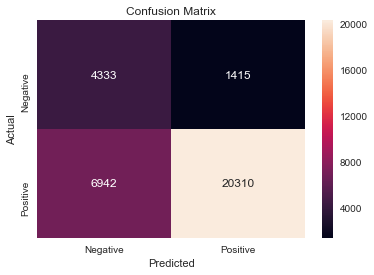

In [48]:
best_t_bow = find_best_threshold(th_bow, fpr_bow, tpr_bow)
conf_matrix(X_train_bow,y_train,X_test_bow,y_test,best_t_bow,clftre_bow)

## [5.2] Applying Decision Trees on TFIDF,<font color='red'> SET 2</font>

#### Hyperparameter tuning

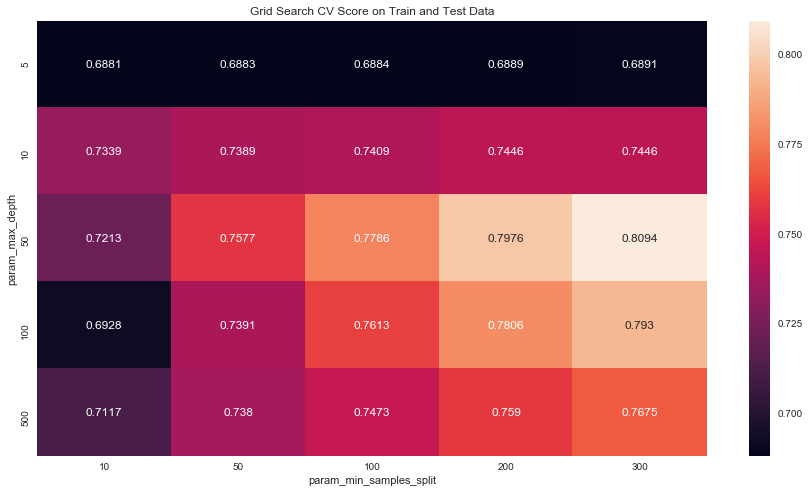

Best depth:  50
Best samples split:  300
Wall time: 31min 17s


In [49]:
%%time
best_depth_tfidf, best_samle_split_tfidf = dtc(X_train_tfidf,y_train)

#### Training the model with best hyperparameter

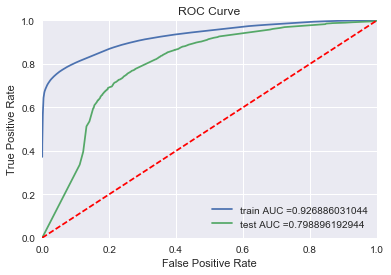

In [50]:
th_tfidf, fpr_tfidf , tpr_tfidf , clftre_tfidf = final_tree(X_train_tfidf,y_train, X_test_tfidf, y_test,best_samle_split_tfidf,best_depth_tfidf)

### [5.2.1] Top 20 important features from<font color='red'> SET 2</font>

In [51]:
ft_2 = clftre_tfidf.feature_importances_
tfidf_ft = tf_idf_vect.get_feature_names()
temp2 = sorted(zip(ft_2,tfidf_ft))
final_feature_tfidf= pd.DataFrame(temp2[:-21:-1])
final_feature_tfidf

,0,1
0,0.121383,not
1,0.083359,great
2,0.038164,best
3,0.037330,delicious
4,0.026888,love
5,0.023121,good
6,0.022759,perfect
7,0.020239,loves
8,0.019136,bad
9,0.018621,disappointed


### [5.2.2] Graphviz visualization of Decision Tree on TFIDF,<font color='red'> SET 2</font>

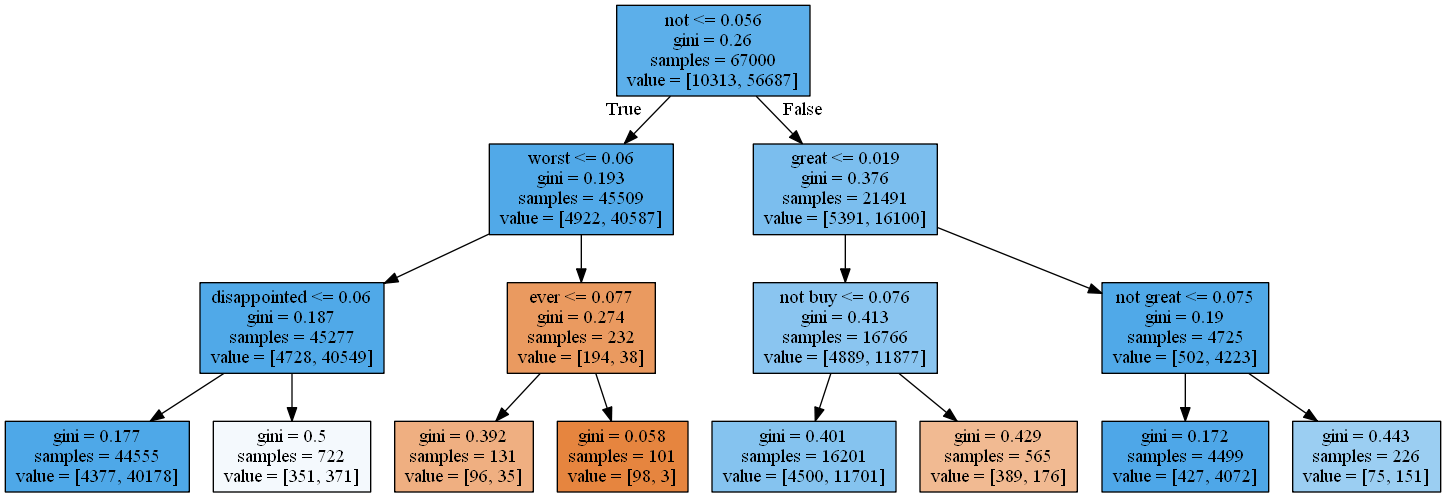

In [52]:
model_tfidf=tree.DecisionTreeClassifier(max_depth=3)
model_tfidf.fit(X_train_tfidf, y_train)
# Create DOT data for visualizing the tree
dot_data_tfidf = tree.export_graphviz(model_tfidf, out_file=None,feature_names=tfidf_ft, filled = True)

# Draw graph
graph_tfidf = pydotplus.graph_from_dot_data(dot_data_tfidf)  

# Show graph
Image(graph_tfidf.create_png())

## [5.3] Applying Decision Trees on AVG W2V,<font color='red'> SET 3</font>

#### Hyperparameter Tuning

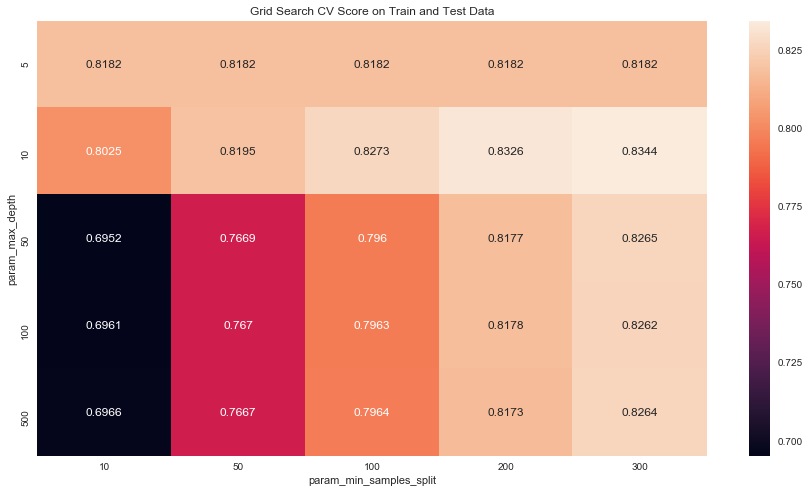

Best depth:  10
Best samples split:  300
Wall time: 6min 20s


In [53]:
%%time
best_depth_avgw2v, best_samle_split_avgw2v = dtc(sent_vectors_train,y_train)

#### Training the model with best hyperparameter

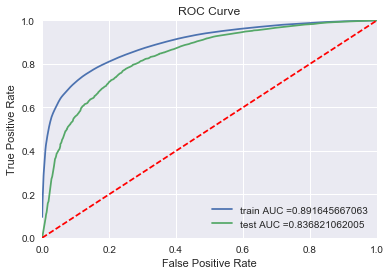

In [54]:
th_avgw2v, fpr_avgw2v , tpr_avgw2v , clftre_avgw2v = final_tree(sent_vectors_train,y_train, sent_vectors_test, y_test,best_samle_split_avgw2v
                                                                ,best_depth_avgw2v)

#### confusion matrix

the maximum value of tpr*(1-fpr) 0.655497793719 for threshold 0.486
Train Data


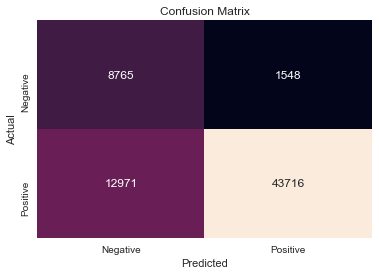

Test Data


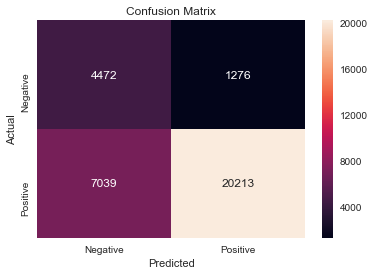

In [55]:
best_t_2_avgw2v = find_best_threshold(th_avgw2v, fpr_avgw2v, tpr_avgw2v)
conf_matrix(sent_vectors_train,y_train,sent_vectors_test,y_test,best_t_2_avgw2v,clftre_avgw2v)

## [5.4] Applying Decision Trees on TFIDF W2V,<font color='red'> SET 4</font>

#### Hyperparameter Tuning

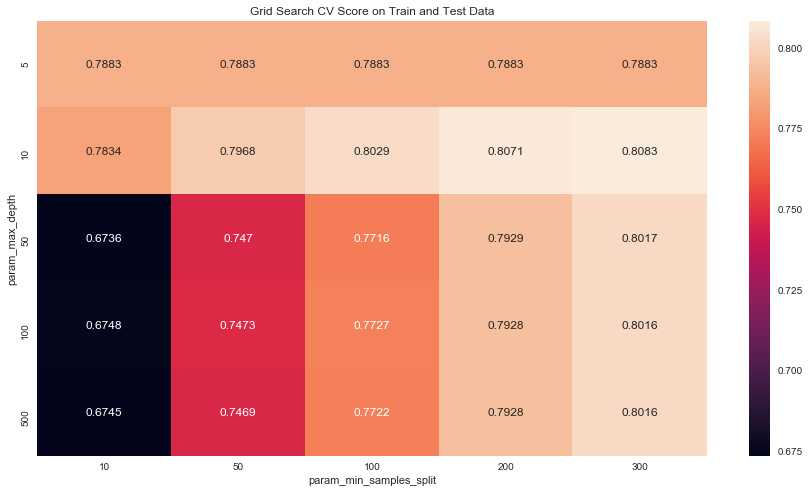

Best depth:  10
Best samples split:  300
Wall time: 6min 17s


In [56]:
%%time
best_depth_tfidfavgw2v, best_samle_split_tfidfavgw2v = dtc(tfidf_sent_vectors_train,y_train)

#### Training the model with best hyperparameter

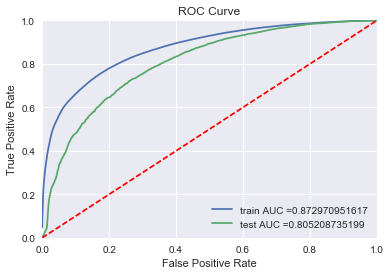

In [57]:
th_tfidfavgw2v, fpr_tfidfavgw2v , tpr_tfidfavgw2v , clftre_tfidfavgw2v = final_tree(tfidf_sent_vectors_train,y_train, tfidf_sent_vectors_test, y_test,best_samle_split_tfidfavgw2v
                                                                ,best_depth_tfidfavgw2v)

#### confusion matrix

the maximum value of tpr*(1-fpr) 0.624168912855 for threshold 0.487
Train Data


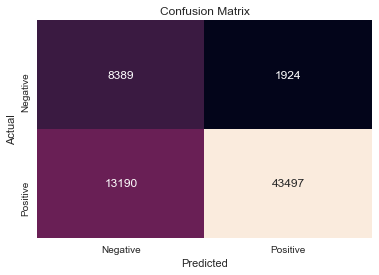

Test Data


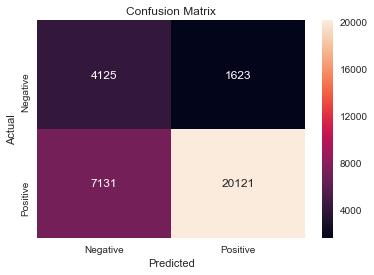

In [58]:
best_t_2_tfidfavgw2v = find_best_threshold(th_tfidfavgw2v, fpr_tfidfavgw2v, tpr_tfidfavgw2v)
conf_matrix(tfidf_sent_vectors_train,y_train,tfidf_sent_vectors_test,y_test,best_t_2_tfidfavgw2v,clftre_tfidfavgw2v)

# [6] Conclusions

In [59]:
# Creating table using PrettyTable library
from prettytable import PrettyTable
vectorizer = ['BOW','TFIDF','Avgw2v','TFIDFW2v']
AUC = [0.83,0.82,0.83,0.79]
Model = ['DecisionTree Classifier','DecisionTree Classifier','DecisionTree Classifier','DecisionTree Classifier']
hyperparameter1= [50,50,10,10]
hyperparameter2= [300,300,200,300]
sno = [1,2,3,4]
# Initializing prettytable
ptable = PrettyTable()
# Adding columns
ptable.add_column("S.NO.",sno)
ptable.add_column("     Vectorizer       ",vectorizer)
ptable.add_column("      Model   "   ,      Model)
ptable.add_column(" Best depth ",hyperparameter1)
ptable.add_column("  Minimum samples split     ",hyperparameter2)
ptable.add_column("  Test AUC              ",AUC)
# Printing the Table
print(ptable)

+-------+------------------------+-------------------------+--------------+------------------------------+--------------------------+
| S.NO. |      Vectorizer        |            Model        |  Best depth  |   Minimum samples split      |   Test AUC               |
+-------+------------------------+-------------------------+--------------+------------------------------+--------------------------+
|   1   |          BOW           | DecisionTree Classifier |      50      |             300              |           0.83           |
|   2   |         TFIDF          | DecisionTree Classifier |      50      |             300              |           0.82           |
|   3   |         Avgw2v         | DecisionTree Classifier |      10      |             200              |           0.83           |
|   4   |        TFIDFW2v        | DecisionTree Classifier |      10      |             300              |           0.79           |
+-------+------------------------+-------------------------+--

In [138]:
!jupyter nbconvert --to html AFFRDT.ipynb

[NbConvertApp] Converting notebook AFFRDT.ipynb to html
[NbConvertApp] Writing 1118944 bytes to AFFRDT.html
